# BL
1. epoch motor planning: -0.5, 0.5 timing
2. epoch motor execution: -0.5, 0.5 timing

In [1]:
import mne
import os
from utils import check_paths
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib qt

# PLANNING / EXECUTION

**GROUP**

Epoching

In [ ]:
# Create planning / execution epochs for subjects
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
task = '_BL' # ['_BL', '_MAIN']
task_stage = '_go' # '_plan' for PLANNING or '_go' for EXECUTION

subs_dir = os.path.join(eeg_data_dir, group)
figs_dir = os.path.join(eeg_data_dir, 'figures', group, 'epochs', task)
check_paths(os.path.join(eeg_data_dir, 'figures', group))
check_paths(os.path.join(eeg_data_dir, 'figures', group, 'epochs'))
check_paths(figs_dir)

# trial infor dictionary
trial_num_data = {'sub': [], 'task_stage': [], 'trial_num': []}

# metadata for each epoch shall include events from the range: [-0.5, 0.7] s,
# i.e. starting with stimulus onset and expanding beyond the end of the epoch
if task_stage == '_plan':
    metadata_tmin, metadata_tmax = -0.5, 1 # [-0.5, 1] for _go or [-0.5, 0.5] for _plan
    # events of interest
    row_events = ['prepare'] # ['prepare']
    # timing of the epochs
    epochs_tmin, epochs_tmax = -0.5, 0.5  # epochs range: [-0.5, 5] for _go or [-0.5, 0.5] for _plan

else:
    metadata_tmin, metadata_tmax = -0.5, 0.5 # [-0.5, 0.5] for _go or [-0.5, 0.5] for _plan
    # events of interest
    row_events = ['key_press'] # ['go']
    # timing of the epochs
    epochs_tmin, epochs_tmax = -0.5, 0.5  # epochs range: [-0.5, 0.5] for _go or [-0.5, 0.5] for _plan

baseline_epo = (epochs_tmin, epochs_tmax) # baseline is the average of the epoch


for sub_name in os.listdir(subs_dir): # os.listdir(subs_dir) OR ['s1_pac_sub00'] # EXCLUDED sub19 - no baseline trigger

    print(f'Creating epochs for {task} task in {sub_name}...')

    preproc_dir = os.path.join(subs_dir, sub_name, 'preproc')
    filt_dir = os.path.join(subs_dir, sub_name, 'preproc', 'filt')
    analysis_dir = os.path.join(preproc_dir, 'analysis')

    eeg_data_path = os.path.join(analysis_dir, f'{sub_name}{task}_reconst.fif')
    raw = mne.io.read_raw_fif(eeg_data_path, preload=True)
    sf = raw.info['sfreq'] # sampling frequency of data

    # Open events from pickle file
    with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'rb') as pickle_file:
        events = pickle.load(pickle_file)

    # check if event time samples are unique
    for i in range(len(events[0]) - 1):
        if events[0][i, 0] == events[0][i+1, 0]:
            print(f'Time sample for events {events[0][i, 2]} and {events[0][i+1, 2]} in trials {i}-{i+1} are not unique!')
            events[0][i+1, 0] = events[0][i, 0] + 1

   # auto-create metadata:
    # this also returns a new events array and an event_id dictionary. we'll see
    # later why this is important
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events[0],
        event_id=events[1],
        tmin=metadata_tmin,
        tmax=metadata_tmax,
        sfreq=raw.info["sfreq"],
        row_events=row_events
    )

    epochs = mne.Epochs(
        raw=raw,
        tmin=epochs_tmin,
        tmax=epochs_tmax,
        events=events,
        event_id=event_id,
        baseline=baseline_epo,
        metadata=metadata,
        reject_by_annotation=True,
        preload=True,
    )

    if task_stage == '_plan':
        epochs = epochs["go.isna() & isi2.isna() & key_press.isna()"]
    
    else:
        epochs = epochs["prepare.isna() & new_trial.isna()"]

    print(f'TOTAL NUMBER OF EPOCHS: {len(epochs)}')

    # Append data to the dictionary
    trial_num_data['sub'].append(sub_name)
    trial_num_data['task_stage'].append(task_stage)
    trial_num_data['trial_num'].append(len(epochs))


    # Save the epochs
    epochs.save(os.path.join(analysis_dir, f"{sub_name}{task}_epochs{task_stage}-epo.fif"), overwrite=True)
    print(f'Epochs for {task}{task_stage} in {sub_name} saved SUCCESSFULLY')

    # Plot ERP
    fig_erp = epochs.average().plot(gfp=True, spatial_colors=True)
    # Save the ERP plot
    fig_erp.savefig(os.path.join(figs_dir, f"{sub_name}{task}{task_stage}_erp_plot.png"), dpi=300)


    spectrum = epochs.compute_psd()
    bands = {'Theta (4-8 Hz)': (4, 8),
            'Alpha (8-12 Hz)': (8, 12),
            'Beta (12-30 Hz)': (12, 30),
            'Gamma (30-50 Hz)': (30, 50),
            'High gamma (50-80 Hz)': (50, 80)}

    fig_psd = spectrum.plot_topomap(bands=bands, vlim="joint", normalize=True)
    fig_psd.savefig(os.path.join(figs_dir, f"{sub_name}{task}{task_stage}_psd_topomap.png"), dpi=300)

    print(f'Figures for {sub_name} saved SUCCESSFULLY')

    plt.close('all')

#save the trial number data to a CSV file
trial_num_df = pd.DataFrame(trial_num_data)
trial_num_df.to_csv(os.path.join(figs_dir, f"{task[1:]}{task_stage}_TRIAL_NUM.csv"), index=False)
print(f'TRIAL NUMBER saved SUCCESSFULLY to {os.path.join(figs_dir, f"{task[1:]}{task_stage}_TRIAL_NUM.csv")}')

print(trial_num_df)

In [117]:
print(trial_num_df)

             sub task_stage  trial_num
0   s1_pac_sub01        _go         84
1   s1_pac_sub07        _go         98
2   s1_pac_sub10        _go        106
3   s1_pac_sub11        _go         96
4   s1_pac_sub22        _go        102
5   s1_pac_sub24        _go         98
6   s1_pac_sub26        _go        100
7   s1_pac_sub29        _go         91
8   s1_pac_sub32        _go         72
9   s1_pac_sub33        _go         97
10  s1_pac_sub38        _go        108
11  s1_pac_sub43        _go        101
12  s1_pac_sub52        _go         99
13  s1_pac_sub58        _go        105
14  s1_pac_sub59        _go         99
15  s1_pac_sub61        _go        106
16  s1_pac_sub63        _go         91
17  s1_pac_sub64        _go        107
18  s1_pac_sub66        _go         99
19  s1_pac_sub67        _go         75
20  s1_pac_sub71        _go        107
21  s1_pac_sub72        _go         85
22  s1_pac_sub76        _go        109
23  s1_pac_sub77        _go        110


ALL ELECTRODES & ALL SUBJECTS

In [ ]:
# eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
# group = 'Y'
# task = '_BL' # ['_BL', '_MAIN']
# task_stage = '_plan' # '_plan' or 'go'
# subs_dir = os.path.join(eeg_data_dir, group)

all_epochs = []

for sub_name in os.listdir(subs_dir): # os.listdir(subs_dir) OR ['s1_pac_sub00']

    preproc_dir = os.path.join(subs_dir, sub_name, 'preproc')
    analysis_dir = os.path.join(preproc_dir, 'analysis')

    epochs_data_path = os.path.join(analysis_dir, f'{sub_name}{task}_epochs{task_stage}-epo.fif')
    epochs = mne.read_epochs(epochs_data_path, preload=True)
    all_epochs.append(epochs)

epochs_all_subs = mne.concatenate_epochs(all_epochs)

group_save_path = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group} group'
epochs_all_subs.save((os.path.join(group_save_path, f"{group}_ALL_SUBS{task}_epochs{task_stage}_ALL-epo.fif")), overwrite=True)

_________________________

Time-frequency

In [ ]:
# task_stage = '_go' # '_plan' or 'go'

for sub_name in os.listdir(subs_dir): # os.listdir(subs_dir) OR ['s1_pac_sub00']
    
    print(f'Creating epochs for {task} task in {sub_name}...')

    preproc_dir = os.path.join(subs_dir, sub_name, 'preproc')
    analysis_dir = os.path.join(preproc_dir, 'analysis')
    tfr_dir = os.path.join(figs_dir, 'TFR')
    check_paths(tfr_dir)

    epochs_data_path = os.path.join(analysis_dir, f'{sub_name}{task}_epochs{task_stage}-epo.fif')
    epochs = mne.read_epochs(epochs_data_path, preload=True)

    freqs = np.logspace(*np.log10([4, 80]), num=40)
    n_cycles = freqs / 2.0  # different number of cycle per frequency
    power, itc = epochs.compute_tfr(
        method="morlet",
        freqs=freqs,
        n_cycles=n_cycles,
        average=True,
        return_itc=True,
        decim=3,
    )

    # Save time-freq analysis output
    power.save(os.path.join(analysis_dir, f"{sub_name}{task}{task_stage}_power-tfr.h5"), overwrite=True)
    itc.save(os.path.join(analysis_dir, f"{sub_name}{task}{task_stage}_itc-tfr.h5"), overwrite=True)

    # plot ITC and Power
    itc_fig = itc.plot(combine='mean', baseline=baseline_epo)[0]
    power_all_fig = power.plot(baseline=baseline_epo, mode="logratio", title='Averaged Power Across Channels', combine='mean')[0]
    power_motor_fig = power.plot(picks=['C1', 'C3', 'C5'], baseline=baseline_epo, mode="logratio", title='Averaged Power Across C1-5 Channels', combine='mean')[0]

    # save ITC and Power plots
    itc_fig.savefig(os.path.join(figs_dir, 'TFR', f"{sub_name}{task}_itc.png"), dpi=300)
    power_all_fig.savefig(os.path.join(figs_dir, 'TFR', f"{sub_name}{task}_power_all.png"), dpi=300)
    power_motor_fig.savefig(os.path.join(figs_dir, 'TFR', f"{sub_name}{task}_power_motor.png"), dpi=300)

    plt.close('all')

TF group

In [ ]:
# group = 'O'
group_save_path = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group} group'

sub_name = 'ALL_subs'
# task = '_BL' # ['_BL', '_MAIN']
# task_stage = '_go' # '_plan' or '_go'

figs_dir = os.path.join('D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\figures', group, 'epochs', task, 'TFR')
check_paths(figs_dir)

epochs_all_subs = mne.read_epochs(os.path.join(group_save_path, f"{group}_{sub_name}{task}_epochs{task_stage}_ALL-epo.fif"), preload=True)
epochs_all_subs

In [124]:
freqs = np.logspace(*np.log10([4, 80]), num=40)
n_cycles = freqs / 2.0  # different number of cycle per frequency
baseline = (-0.5, -0.1)

power, itc = epochs_all_subs.compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,
    decim=3,
    n_jobs=-1
)

# Save time-freq analysis output
power.save(os.path.join(group_save_path, f"{group}_{sub_name}{task}{task_stage}_power-tfr.h5"), overwrite=True)
itc.save(os.path.join(group_save_path, f"{group}_{sub_name}{task}{task_stage}_itc-tfr.h5"), overwrite=True)

# plot ITC and Power
itc_fig = itc.plot(combine='mean', baseline=baseline, title=f'Group: {group}: Finger-tapping task: {task_stage[1:]}. ITC', cmap='magma')[0]
power_all_fig = power.plot(baseline=baseline, mode="logratio", title=f'Group: {group}: Finger-tapping task: {task_stage[1:]}. Averaged Power', combine='mean', cmap='magma')[0]

# save ITC and Power plots
itc_fig.savefig(os.path.join(figs_dir, f"{group}_{sub_name}{task}{task_stage}_itc.png"), dpi=300)
power_all_fig.savefig(os.path.join(figs_dir, f"{group}_{sub_name}{task}{task_stage}_power_all.png"), dpi=300)

# plt.close('all')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  60 | elapsed:    9.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.1s finished


Applying baseline correction (mode: mean)
Applying baseline correction (mode: logratio)


In [ ]:
# from mne.time_frequency import read_tfrs
# task_stage = '_go'
# power = read_tfrs(os.path.join(group_save_path, 'ALL_subs_BL_go_power-tfr.h5'))
# itc = read_tfrs(os.path.join(group_save_path, 'ALL_subs_BL_go_itc-tfr.h5'))

# # plot ITC and Power
# itc_fig = itc.plot(combine='mean', baseline=baseline, title=f'Group: {group}: Finger-tapping task: {task_stage[1:]}. ITC', cmap='magma')[0]
# power_all_fig = power.plot(baseline=baseline, mode="logratio", title=f'Group: {group}: Finger-tapping task: {task_stage[1:]}. Averaged Power', combine='mean', cmap='magma')[0]

# # save ITC and Power plots
# itc_fig.savefig(os.path.join(figs_dir, f"{group}_{sub_name}{task}{task_stage}_itc.png"), dpi=300)
# power_all_fig.savefig(os.path.join(figs_dir, f"{group}_{sub_name}{task}{task_stage}_power_all.png"), dpi=300)


_________________________________

Dirty field

**SINGLE SUB**

In [ ]:
# set EEG data path, group, task and subject
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
sub_name = 's1_pac_sub01' # specify the subject you want to analyse 's1_pac_sub52'

preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')
filt_dir = os.path.join(preproc_dir, 'filt')
analysis_dir = os.path.join(preproc_dir, 'analysis')
task = '_BL'

eeg_data_path = os.path.join(analysis_dir, f'{sub_name}{task}_reconst.fif')
raw = mne.io.read_raw_fif(eeg_data_path, preload=True)

# raw.plot()

# Open events from pickle file
with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'rb') as pickle_file:
    events = pickle.load(pickle_file)

# # check if event time samples are unique
# for i in range(len(events[0]) - 1):
#     if events[0][i, 0] == events[0][i+1, 0]:
#         print(f'Time sample for events {events[0][i, 2]} and {events[0][i+1, 2]} in trials {i}-{i+1} are not unique!')
#         events[0][i+1, 0] = events[0][i, 0] + 1


Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_BL_reconst.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 171384 =      0.000 ...   342.768 secs
Ready.
Reading 0 ... 171384  =      0.000 ...   342.768 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_34432\4176590668.py:12: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_BL_reconst.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_data_path, preload=True)


In [5]:
events[1].keys()

dict_keys(['0, Impedance', 'new_trial', 'break_instr', 'finish_instr', 'prepare', 'isi1', 'go', 'isi2', 'key_press'])

**GET TIMING OF THE EPOCHS**

In [11]:
events

{'0, Impedance': 0,
 'new_trial': 10,
 'break_instr': 102,
 'finish_instr': 103,
 'prepare': 11,
 'isi1': 12,
 'go': 13,
 'isi2': 14,
 'key_press': 15}

In [29]:
events_array, event_id = events[0], events[1]

In [30]:
# Short names for event codes
code_new_trial = event_id['new_trial']
code_prepare   = event_id['prepare']
code_isi1      = event_id['isi1']
code_go        = event_id['go']
code_isi2      = event_id['isi2']

# Containers for timing differences
diff_newtrial_prepare = []
diff_prepare_isi1 = []
diff_isi1_go = []
diff_go_isi2 = []
diff_isi2_newtrial = []  # NEW

n_events = len(events_array)
sfreq = raw.info['sfreq']  # Sampling frequency

for i in range(n_events):
    if events_array[i, 2] == code_new_trial:
        # --- find prepare after new_trial
        idx_prepare = i + 1 if i + 1 < n_events and events_array[i + 1, 2] == code_prepare else None
        if idx_prepare is None:
            continue

        # --- find isi1 after prepare
        idx_isi1 = idx_prepare + 1 if idx_prepare + 1 < n_events and events_array[idx_prepare + 1, 2] == code_isi1 else None
        if idx_isi1 is None:
            continue

        # --- find go after isi1
        idx_go = idx_isi1 + 1 if idx_isi1 + 1 < n_events and events_array[idx_isi1 + 1, 2] == code_go else None
        if idx_go is None:
            continue

        # --- find first isi2 after go (skip key_press etc.)
        idx_isi2 = None
        for j in range(idx_go + 1, n_events):
            if events_array[j, 2] == code_isi2:
                idx_isi2 = j
                break
        if idx_isi2 is None:
            continue

        # --- find first new_trial after isi2 (skip key_press etc.)
        idx_next_new_trial = None
        for j in range(idx_isi2 + 1, n_events):
            if events_array[j, 2] == code_new_trial:
                idx_next_new_trial = j
                break
        if idx_next_new_trial is None:
            continue

        # --- store differences (in seconds)
        diff_newtrial_prepare.append((events_array[idx_prepare, 0] - events_array[i, 0]) / sfreq)
        diff_prepare_isi1.append((events_array[idx_isi1, 0] - events_array[idx_prepare, 0]) / sfreq)
        diff_isi1_go.append((events_array[idx_go, 0] - events_array[idx_isi1, 0]) / sfreq)
        diff_go_isi2.append((events_array[idx_isi2, 0] - events_array[idx_go, 0]) / sfreq)
        diff_isi2_newtrial.append((events_array[idx_next_new_trial, 0] - events_array[idx_isi2, 0]) / sfreq)  # NEW

# --- Average times
print(f"Avg new_trial → prepare: {np.mean(diff_newtrial_prepare):.3f} s")
print(f"Avg prepare → isi1: {np.mean(diff_prepare_isi1):.3f} s")
print(f"Avg isi1 → go: {np.mean(diff_isi1_go):.3f} s")
print(f"Avg go → isi2: {np.mean(diff_go_isi2):.3f} s")
print(f"Avg isi2 → new_trial: {np.mean(diff_isi2_newtrial):.3f} s")  # NEW


Avg new_trial → prepare: 0.016 s
Avg prepare → isi1: 1.433 s
Avg isi1 → go: 0.117 s
Avg go → isi2: 0.313 s
Avg isi2 → new_trial: 0.667 s


In [31]:
print("MIN new_trial → prepare: {:.3f} s".format(np.min(diff_newtrial_prepare)))
print("MAX new_trial → prepare: {:.3f} s".format(np.max(diff_newtrial_prepare)))

print("MIN prepare → isi1: {:.3f} s".format(np.min(diff_prepare_isi1)))
print("MAX prepare → isi1: {:.3f} s".format(np.max(diff_prepare_isi1)))

print("MIN isi1 → go: {:.3f} s".format(np.min(diff_isi1_go)))
print("MAX isi1 → go: {:.3f} s".format(np.max(diff_isi1_go)))

print("MIN go → isi2: {:.3f} s".format(np.min(diff_go_isi2)))
print("MAX go → isi2: {:.3f} s".format(np.max(diff_go_isi2)))

print(f"MIN isi2 → new_trial: {np.min(diff_isi2_newtrial):.3f} s") 
print(f"MAX isi2 → new_trial: {np.max(diff_isi2_newtrial):.3f} s") 

MIN new_trial → prepare: 0.010 s
MAX new_trial → prepare: 0.028 s
MIN prepare → isi1: 1.432 s
MAX prepare → isi1: 1.436 s
MIN isi1 → go: 0.114 s
MAX isi1 → go: 0.118 s
MIN go → isi2: 0.132 s
MAX go → isi2: 1.034 s
MIN isi2 → new_trial: 0.500 s
MAX isi2 → new_trial: 13.166 s


In [64]:
# metadata for each epoch shall include events from the range: [0.0, 1.5] s,
# i.e. starting with stimulus onset and expanding beyond the end of the epoch
metadata_tmin, metadata_tmax = -0.5, 1

# events of interest
row_events = ['prepare']

# auto-create metadata:
# this also returns a new events array and an event_id dictionary. we'll see
# later why this is important
metadata, events_plan, event_id_plan = mne.epochs.make_metadata(
    events=events[0],
    event_id=events[1],
    tmin=metadata_tmin,
    tmax=metadata_tmax,
    sfreq=raw.info["sfreq"],
    row_events=row_events
)

# let's look at what we got!
metadata

,event_name,"0, Impedance",new_trial,break_instr,finish_instr,prepare,isi1,go,isi2,key_press
2,prepare,NaN,-0.060,NaN,NaN,0.0,NaN,NaN,NaN,NaN
8,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN
14,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN
20,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN
26,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
687,prepare,NaN,-0.018,NaN,NaN,0.0,NaN,NaN,NaN,NaN
693,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN
699,prepare,NaN,-0.018,NaN,NaN,0.0,NaN,NaN,NaN,NaN
705,prepare,NaN,-0.016,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [65]:
epochs_tmin, epochs_tmax = -0.5, 0.5  # epochs range: [-0.1, 0.4] s
baseline = (epochs_tmin, -0.1)

epochs_plan = mne.Epochs(
    raw=raw,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=events_plan,
    event_id=event_id_plan,
    baseline=baseline,
    metadata=metadata,
    reject_by_annotation=True,
    preload=True,
)

Adding metadata with 10 columns
119 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 119 events and 501 original time points ...
20 bad epochs dropped


In [67]:
epochs_plan = epochs_plan["go.isna() & isi2.isna() & key_press.isna()"]
epochs_plan

<Epochs | 99 events (all good), -0.5 – 0.5 s (baseline -0.5 – -0.1 s), ~23.2 MB, data loaded, with metadata,
 'prepare': 99>

In [ ]:
epochs_plan.plot(events=events[0], n_channels=64)

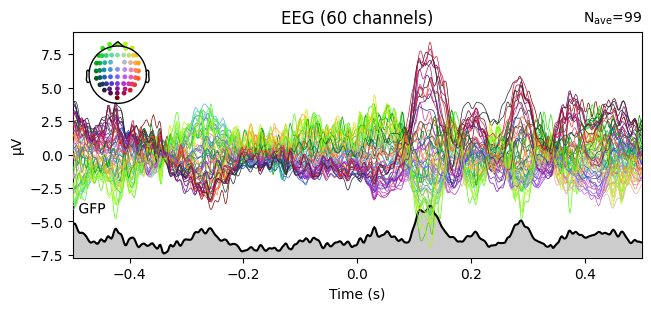

In [68]:
epochs_plan.average().plot(gfp=True, spatial_colors=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting amplitude spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


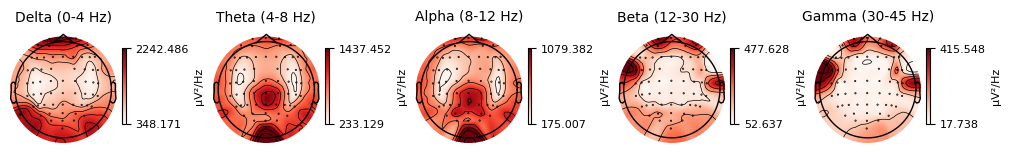

In [69]:
epochs_plan.compute_psd().plot(exclude="bads", amplitude=True)

spectrum = epochs_plan.compute_psd()
spectrum.plot_topomap()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


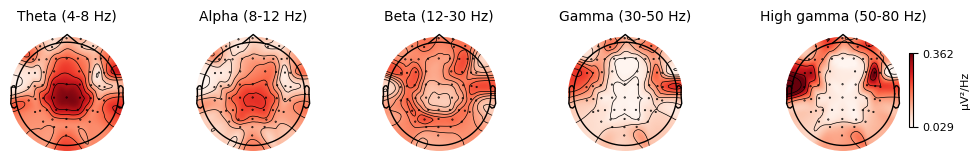

In [70]:
spectrum = epochs_plan.compute_psd()
bands = {'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12),
         'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-50 Hz)': (30, 50),
         'High gamma (50-80 Hz)': (50, 80)}

spectrum.plot_topomap(bands=bands, vlim="joint", normalize=True)

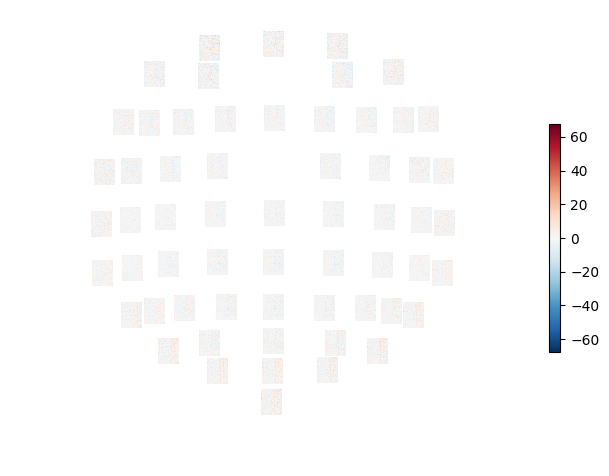

In [71]:
layout = mne.channels.find_layout(epochs_plan.info, ch_type="eeg")
epochs_plan.plot_topo_image(
    layout=layout, fig_facecolor="w", font_color="k", sigma=1
)

In [72]:
epo_alpha = epochs_plan.copy().filter(l_freq=8, h_freq=12, n_jobs=-1)
epo_beta = epochs_plan.copy().filter(l_freq=12, h_freq=30, n_jobs=-1)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



C:\Users\a1902989\AppData\Local\Temp\ipykernel_31684\3699951318.py:1: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  epo_alpha = epochs_plan.copy().filter(l_freq=8, h_freq=12, n_jobs=-1)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:    3.2s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=-1)]: Done 5484 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 5940 out of 5940 | elapsed:    3.4s finished
C:\Users\a1902989\AppData\Local\Temp\ipykernel_31684\3699951318.py:2: RuntimeWarning: filter_length (551) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  epo_beta = epochs_plan.copy().filter(l_freq=12, h_freq=30, n_jobs=-1)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 5532 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 5940 out of 5940 | elapsed:    0.3s finished


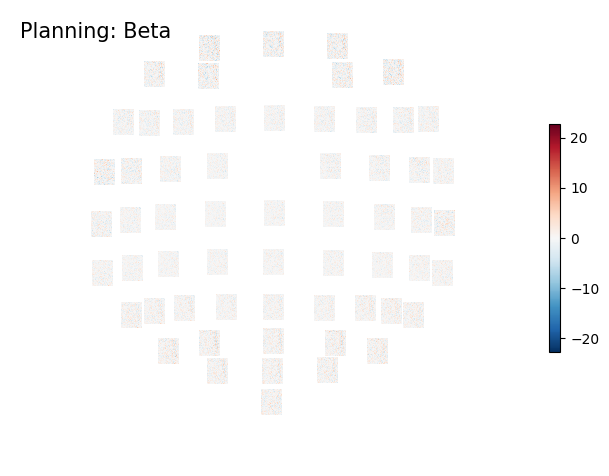

In [73]:
epo_alpha["prepare"].plot_topo_image(
    layout=layout, fig_facecolor="w", font_color="k", sigma=1,
    title='Planning: Alpha'
)
epo_beta["prepare"].plot_topo_image(
    layout=layout, fig_facecolor="w", font_color="k", sigma=1,
    title='Planning: Beta'
)

__________________________

TIME-FREQUENCY

In [74]:
freqs = np.logspace(*np.log10([4, 80]), num=40)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = epochs_plan.compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,
    decim=3,
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


In [ ]:
itc.plot(combine='mean', baseline=baseline)

In [ ]:
power.plot(baseline=baseline, mode="logratio", title='Averaged Power Across Channels', combine='mean')
power.plot(picks=['C1', 'C3', 'C5'], baseline=baseline, mode="logratio", title='Averaged Power Across C1-5 Channels', combine='mean')

----------------------

PAC DRAFTS

In [32]:
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude


my data

In [ ]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
task = '_BL' # ['_BL', '_MAIN']
task_stage = '_plan' # '_plan' or '_go'

subs_dir = os.path.join(eeg_data_dir, group)
figs_dir = os.path.join(eeg_data_dir, 'figures', group, 'epochs', task, task_stage)
check_paths(figs_dir)

sub_name = 's1_pac_sub01'

preproc_dir = os.path.join(subs_dir, sub_name, 'preproc')
analysis_dir = os.path.join(preproc_dir, 'analysis')

epochs_data_path = os.path.join(analysis_dir, f'{sub_name}{task}_epochs{task_stage}-epo.fif')
epochs = mne.read_epochs(epochs_data_path, preload=True)
epochs


Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub07\preproc\analysis\s1_pac_sub07_BL_epochs_plan-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
102 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<EpochsFIF | 102 events (all good), -0.5 – 0.5 s (baseline -0.5 – -0.1 s), ~23.9 MB, data loaded, with metadata,
 'prepare': 102>

In [4]:
pac_figs_dir = os.path.join(eeg_data_dir, 'figures', 'PAC')
check_paths(pac_figs_dir)

In [101]:
# Load the data from an MNE Epochs object (e.g., shape: epochs x channels x time)
data = epochs.pick("eeg").get_data()[:,4,:]  # Shape: (n_epochs, n_channels, n_times) C3
# data = np.mean(epochs.get_data(), axis=1)
sf = epochs.info['sfreq']  # Sampling frequency
times = epochs.times

# Initialize PAC object
# pac = Pac(idpac=(1, 2, 3), f_pha=(2, 12, 1), f_amp=(20, 80, 5), dcomplex='wavelet')

print(f"DATA: (n_trials, n_times)={data.shape}; SAMPLING FREQUENCY={sf}Hz; "
      f"TIME VECTOR: n_times={len(times)}")

DATA: (n_trials, n_times)=(99, 501); SAMPLING FREQUENCY=500.0Hz; TIME VECTOR: n_times=501


In [102]:
plt.figure(figsize=(8, 6))
plt.plot(times, data.mean(0))
plt.autoscale(axis='x', tight=True)
plt.title("Mean raw data across trials of C3 electrode", fontsize=18)
plt.xlabel('Times (in seconds)', fontsize=15)
plt.ylabel('V', fontsize=15)

Text(0, 0.5, 'V')

In [70]:
itc = ITC(data, sf, f_pha=(2, 20, 1, .2), dcomplex='wavelet')

Inter-Trials Coherence (ITC)
    extracting 85 phases


In [71]:
itc.plot(times=times, cmap='plasma', fz_labels=15, fz_title=18)
plt.show()

In [ ]:
psd = PSD(data, sf)
psd.plot()

In [ ]:
rp_obj = EventRelatedPac(f_pha=[8, 12], f_amp=(30, 80, 2, 0.5))
erpac = rp_obj.filterfit(sf, data, method='gc', smooth=100)

In [78]:
plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC theta-gamma',
               fz_labels=15, fz_title=18)

plt.show()

In [ ]:
peak = PeakLockedTF(data, sf, cue=0., times=times, f_pha=[8, 12],
                    f_amp=(30, 80, 2, 0.5))

In [82]:
plt.figure(figsize=(8, 8))
ax_1, ax_2 = peak.plot(zscore=True, baseline=(0, 250), cmap='Spectral_r',
                       vmin=-1, vmax=2)
plt.title('Peak-locked TF: theta-gamma')
plt.tight_layout()
plt.show()

rest vs plan

In [89]:
p_obj = Pac(idpac=(6, 0, 0), f_pha=(3, 9, 2, .1), f_amp=(30, 80, 2, 0.5))
# extract all of the phases and amplitudes
pha_p = p_obj.filter(sf, data, ftype='phase')
amp_p = p_obj.filter(sf, data, ftype='amplitude')
# define time indices where rest, planning and execution are defined
time_rest = slice(0, 250)
time_prep = slice(250, 500)

# define phase / amplitude during rest / planning / execution
pha_rest, amp_rest = pha_p[..., time_rest], amp_p[..., time_rest]
pha_prep, amp_prep = pha_p[..., time_prep], amp_p[..., time_prep]

# compute PAC inside rest, planning, and execution
pac_rest = p_obj.fit(pha_rest, amp_rest).mean(-1)
pac_prep = p_obj.fit(pha_prep, amp_prep).mean(-1)


Phase Amplitude Coupling object defined
    true PAC estimation using Gaussian Copula PAC (gcPac)
    true PAC estimation using Gaussian Copula PAC (gcPac)


In [86]:
vmax = np.max([pac_rest.max(), pac_prep.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')
plt.figure(figsize=(14, 4))
plt.subplot(121)
p_obj.comodulogram(pac_rest, title="PAC Rest [-0.5, 0]s", **kw)
plt.subplot(122)
p_obj.comodulogram(pac_prep, title="PAC Planning [0, 0.5]s", **kw)
plt.ylabel('')
plt.tight_layout()
plt.show()

stats

In [90]:
# still using the Gaussian-Copula PAC but this time, we also select the method
# for computing the permutations
p_obj.idpac = (6, 2, 0)
# compute pac and 200 surrogates
pac_prep = p_obj.fit(pha_p[..., time_prep], amp_p[..., time_prep], n_perm=200,
                     random_state=0)
# get the p-values
mcp = 'maxstat'
pvalues = p_obj.infer_pvalues(p=0.05, mcp=mcp)

    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=0)
    infer p-values at (p=0.05, mcp=maxstat)
    infer p-values at (p=0.05, mcp=maxstat)


In [91]:
# sphinx_gallery_thumbnail_number = 7
plt.figure(figsize=(8, 6))
title = (r"Significant theta$\Leftrightarrow$gamma coupling occurring during "
         f"the motor planning phase\n(p<0.05, {mcp}-corrected for multiple "
          "comparisons)")
# plot the non-significant pac in gray
pac_prep_ns = pac_prep.mean(-1).copy()
pac_prep_ns[pvalues < .05] = np.nan
p_obj.comodulogram(pac_prep_ns, cmap='gray', vmin=np.nanmin(pac_prep_ns),
                   vmax=np.nanmax(pac_prep_ns), colorbar=False)
# plot the significant pac in color
pac_prep_s = pac_prep.mean(-1).copy()
pac_prep_s[pvalues >= .05] = np.nan
p_obj.comodulogram(pac_prep_s, cmap='Spectral_r', vmin=np.nanmin(pac_prep_s),
                   vmax=np.nanmax(pac_prep_s), title=title)
plt.gca().invert_yaxis()
plt.show()

C:\Users\a1902989\AppData\Local\Temp\ipykernel_12828\922743022.py:14: RuntimeWarning: All-NaN slice encountered
  p_obj.comodulogram(pac_prep_s, cmap='Spectral_r', vmin=np.nanmin(pac_prep_s),
C:\Users\a1902989\AppData\Local\Temp\ipykernel_12828\922743022.py:15: RuntimeWarning: All-NaN slice encountered
  vmax=np.nanmax(pac_prep_s), title=title)


In [36]:
width, step = 3, .2
theta = [3, 9]
alpha = [6, 14]
gamma_set = (30, 80, 2, 0.5)

In [37]:
# Extract only EEG channel names from the Epochs object
eeg_channel_names = epochs_all_subs.copy().pick("eeg").ch_names
print(eeg_channel_names)


['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz']


In [38]:
sf = epochs_all_subs.info['sfreq']  # Sampling frequency
times = epochs_all_subs.times

In [41]:
pac_figs_dir = os.path.join(eeg_data_dir, 'figures', 'PAC', task)
check_paths(pac_figs_dir)

In [ ]:
sub_name = 'ALL_subs'

for i in range(len(eeg_channel_names)):
    # Load the data from an MNE Epochs object (e.g., shape: epochs x channels x time)
    data = epochs_all_subs.pick("eeg").get_data()[:,i,:]  # Shape: (n_epochs, n_channels, n_times)

    print(f"DATA: (n_trials, n_times)={data.shape}; SAMPLING FREQUENCY={sf}Hz; "
        f"TIME VECTOR: n_times={len(times)}")
    
    # MEAN RAW data from the electrode - plot
    fig = plt.figure(figsize=(8, 6))
    plt.plot(times, data.mean(0))
    plt.autoscale(axis='x', tight=True)
    plt.title(f"Mean raw data across trials of {eeg_channel_names[i]} electrode", fontsize=18)
    plt.xlabel('Times (in seconds)', fontsize=15)
    plt.ylabel('V', fontsize=15)

    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_mean_raw_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_mean_raw_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
    plt.close(fig)

    # inter-trial coherence (ITC) ans power spectrum density (PSD) - plots
    itc = ITC(data, sf, f_pha=(2, 30, 1, .2), dcomplex='wavelet')
    ax = itc.plot(times=times, cmap='plasma', fz_labels=15, fz_title=18)
    ax.set_title(f"ITC Plot_{eeg_channel_names[i]}", fontsize=18)
    fig = ax.get_figure()  # Get the parent figure from the Axes object
    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_ITC_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_ITC_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
    plt.close(fig)

    psd = PSD(data, sf)
    ax = psd.plot()
    ax.set_title(f"PSD Plot_{eeg_channel_names[i]}", fontsize=18)
    fig = ax.get_figure()
    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PSD_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PSD_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
    plt.close(fig)

    for j in [theta, alpha]:
        print(j)

        if j == theta:
            phase_name = 'theta'
        else:
            phase_name = 'alpha'

        # Event-related PAC - plot
        rp_obj = EventRelatedPac(f_pha=j, f_amp=gamma_set)
        erpac = rp_obj.filterfit(sf, data, method='gc', smooth=100)

        plt.figure(figsize=(8, 6))
        ax = rp_obj.pacplot(erpac.squeeze(), times, rp_obj.yvec, xlabel='Time',
                    ylabel='Amplitude frequency (Hz)',
                    title=f'{eeg_channel_names[i]}: Event-Related PAC {phase_name}-gamma',
                    fz_labels=15, fz_title=18)
        fig = ax.get_figure()
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_ERPac_{phase_name}_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_ERPac_{phase_name}_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
        plt.close(fig)

        # time-frequency map based on phase peak - plot
        peak = PeakLockedTF(data, sf, cue=0., times=times, f_pha=j, f_amp=gamma_set)
        plt.figure(figsize=(8, 8))
        ax = peak.plot(zscore=True, baseline=(0, 250), cmap='Spectral_r',
                            vmin=-1, vmax=2)[0]
        plt.title(f'{eeg_channel_names[i]}: Peak-locked TF: {phase_name}-gamma')
        plt.tight_layout()
        fig = ax.get_figure()
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_peak_lockedTF_{phase_name}_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_peak_lockedTF_{phase_name}_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
        plt.close(fig)


        # # PAC for planning
        # j[:] = [*j, width, step]
        phase = tuple((*j, width, step))
        print(phase)

        p_obj = Pac(idpac=(6, 0, 0), f_pha=phase, f_amp=gamma_set)
        # extract all of the phases and amplitudes
        pha_p = p_obj.filter(sf, data, ftype='phase')
        amp_p = p_obj.filter(sf, data, ftype='amplitude')

        # define time indices where planning is defined
        time_all = slice(250, 500)

        # define phase / amplitude during planning
        pha_prep, amp_prep = pha_p[..., time_all], amp_p[..., time_all]

        # compute PAC inside planning
        pac_prep = p_obj.fit(pha_prep, amp_prep).mean(-1)

        vmax = np.max(pac_prep.max())
        kw = dict(vmax=vmax, vmin=.04, cmap='viridis')
        plt.figure(figsize=(8, 6))
        ax = p_obj.comodulogram(pac_prep, title="PAC Planning", **kw)
        fig = ax.get_figure()
        plt.ylabel('')
        plt.tight_layout()
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PAC_plan_{phase_name}_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PAC_plan_{phase_name}_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
        plt.close(fig)


        # # STATISTICS
        # using the Gaussian-Copula PAC but this time, we also select the method
        # for computing the permutations
        p_obj.idpac = (6, 2, 0)
        # compute pac and 200 surrogates
        pac_prep = p_obj.fit(pha_p[..., time_all], amp_p[..., time_all], n_perm=200,
                             random_state=0)
        # get the p-values
        mcp = 'maxstat'
        pvalues = p_obj.infer_pvalues(p=0.05, mcp=mcp)

        # sphinx_gallery_thumbnail_number = 7
        plt.figure(figsize=(8, 6))
        title = (f'''Significant {phase_name}-gamma coupling\n
                 occurring during the motor planning phase\n
                 (p<0.05, {mcp}-corrected for multiple comparisons''')

        # plot the non-significant pac in gray
        pac_prep_ns = pac_prep.mean(-1).copy()
        pac_prep_ns[pvalues < .05] = np.nan
        p_obj.comodulogram(pac_prep_ns, cmap='gray', vmin=np.nanmin(pac_prep_ns),
                           vmax=np.nanmax(pac_prep_ns), colorbar=False)
        
        # plot the significant pac in color
        pac_prep_s = pac_prep.mean(-1).copy()
        pac_prep_s[pvalues >= .05] = np.nan
        ax = p_obj.comodulogram(pac_prep_s, cmap='Spectral_r', vmin=np.nanmin(pac_prep_s),
                           vmax=np.nanmax(pac_prep_s), title=title)
        plt.gca().invert_yaxis()
        fig = ax.get_figure()
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PAC_STATS_{phase_name}_{eeg_channel_names[i]}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(pac_figs_dir, f"{sub_name}_PAC_STATS_{phase_name}_{eeg_channel_names[i]}.fig"), dpi=300, bbox_inches='tight')
        plt.close(fig)



In [9]:
os.path.join(pac_figs_dir, f"{sub_name}_PAC_STATS_{phase_name}_{eeg_channel_names[i]}.png")

'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\figures\\PAC\\s1_pac_sub01_PAC_STATS_theta_Fp2.png'

In [10]:
print(f"Electrode: {eeg_channel_names[i]}, Phase shape: {pha_p.shape}, Amplitude shape: {amp_p.shape}")

Electrode: Fp2, Phase shape: (5, 99, 501), Amplitude shape: (96, 99, 501)


In [21]:
pha_p.shape

(11, 99, 501)

In [ ]:
if pha_p.ndim == 3:  # Check if the phase data is in the correct shape
    pha_p = np.deg2rad(pha_p)  # Convert phase to radians

In [103]:
fig = plt.figure(figsize=(8, 6))
plt.plot(times, data.mean(0))
plt.autoscale(axis='x', tight=True)
plt.title("Mean raw data across trials of C3 electrode", fontsize=18)
plt.xlabel('Times (in seconds)', fontsize=15)
plt.ylabel('V', fontsize=15)

AttributeError: 'Figure' object has no attribute 'plot'

In [ ]:
electrodes = zip(len(epochs.get_data()[0,:,0]))

stopped here

__________________

In [36]:
pac_results = []
for i in range(data.shape[1]):  # Loop over channels
    pac_result = pac.filterfit(sf, data[:, i, :])  # Compute PAC on each channel
    pac_results.append(pac_result)  # Append results for each channel


    extract phases (n_pha=2) and amplitudes (n_amps=2)
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=9309)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract then divide by the mean of surrogates)
    extract phases (n_pha=2) and amplitudes (n_amps=2)
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=7288)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract then divide by the mean of surrogates)
    extract phases (n_pha=2) and amplitudes (n_amps=2)
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permu

In [52]:
len(pac_results)

61

In [55]:
pac_results[0].shape

(2, 2, 110)

In [44]:
epochs.info['ch_names']

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Iz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'Fpz',
 'CPz',
 'POz',
 'Oz',
 'BIP3']

In [46]:
type(pac)

tensorpac.pac.Pac

In [67]:
pac_result[0, :, 0]

array([ 0.27716964, -0.54190301])

In [70]:
# Example: Select the first phase and amplitude frequency
phase_idx = 0  # Index for the phase frequency you want to visualize
amp_idx = 0    # Index for the amplitude frequency you want to visualize

for i, pac_result in enumerate(pac_results):
    xvec = pac.f_pha
    yvec = pac.f_amp

    # Select specific indices for phase and amplitude
    pac_result_selected = pac_result[phase_idx, :, :]  # Shape: (time_points)

    pac.pacplot(pac_result_selected, xvec=xvec, yvec=yvec, title=f"PAC for Channel {i}")


ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (2, 2, 2)

In [63]:
pac_result.shape

(2, 2, 110)

_______________

DIRTY FIELD

In [ ]:
# # Permanently changes the pandas settings
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

# # All dataframes hereafter reflect these changes.
# display(metadata)

# print('**RESET_OPTIONS**')

# # Resets the options
# pd.reset_option('all')
# display(df)

In [ ]:
planning_idx = np.where(events[0][:, 2] == 11)
planning_events = events[0][planning_idx]
planning_events

array([[ 11373,      0,     11],
       [ 12581,      0,     11],
       [ 13773,      0,     11],
       [ 14898,      0,     11],
       [ 16040,      0,     11],
       [ 17223,      0,     11],
       [ 18414,      0,     11],
       [ 19656,      0,     11],
       [ 20831,      0,     11],
       [ 22123,      0,     11],
       [ 23673,      0,     11],
       [ 24848,      0,     11],
       [ 25956,      0,     11],
       [ 27065,      0,     11],
       [ 28206,      0,     11],
       [ 29398,      0,     11],
       [ 30598,      0,     11],
       [ 31715,      0,     11],
       [ 32915,      0,     11],
       [ 34056,      0,     11],
       [ 35382,      0,     11],
       [ 36565,      0,     11],
       [ 38114,      0,     11],
       [ 39348,      0,     11],
       [ 40615,      0,     11],
       [ 41814,      0,     11],
       [ 43048,      0,     11],
       [ 44231,      0,     11],
       [ 45431,      0,     11],
       [ 46689,      0,     11],
       [ 4

In [ ]:
print(epochs_plan.drop_log)

In [ ]:
print(all(proj["active"] for proj in epochs_plan.info["projs"]))